# Figure S6: Distribution of misfits
This notebook produces figure S6 of Tankersley et al. 2022. The figure shows the distribution of misfits between OIB, ANTOSTRAT, and ROSETTA-Ice basement models. 

In [2]:
# import necessary python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import pygmt
import os
import geopandas as gpd

In [3]:
# all file paths assume this notebook is in /RIS_basement_sediment/figures
pwd = os.getcwd()
pwd

'C:\\Users\\mtankersley\\Documents\\Python_Scripts\\RIS_basement_sediment\\Figures'

## Load data

In [4]:
# OIB to ANTOSTRAT comparison
oib_to_anto = pd.read_csv("../data/results/oib_basement.csv", header=0, index_col=None,sep=',', compression='gzip')
oib_to_anto = oib_to_anto[['Line', 'ANTOSTRAT_basement', 'filt_clip']]
oib_to_anto.rename(columns={'filt_clip':'OIB_basement'}, inplace=True) 
oib_to_anto['dif'] = oib_to_anto.ANTOSTRAT_basement - oib_to_anto.OIB_basement
oib_to_anto['abs_dif'] = np.abs(oib_to_anto.dif)

# ROSETTTA to OIB comparison
rosetta_to_oib = pd.read_csv("../data/results/rs_oib_basement.csv", header=0, index_col=None,sep=',', compression='gzip')
rosetta_to_oib = rosetta_to_oib[['Line', 'filt_clip','filt_clip_oib']]
rosetta_to_oib.rename(columns={'filt_clip':'ROSETTA_basement', 'filt_clip_oib':'OIB_basement'}, inplace=True) 
rosetta_to_oib['dif'] = rosetta_to_oib.ROSETTA_basement - rosetta_to_oib.OIB_basement
rosetta_to_oib['abs_dif'] = np.abs(rosetta_to_oib.dif)

# prep OIB & ROSETTA magnetics data
# these csv are the outputs of the Werner deconvolution process, which was performed in Geosoft Oasis Montaj.
ROSETTA='../data/input/Geosoft_mag_data.csv.gz'
OIB='../data/input/Geosoft_Werner_output.csv.gz'

# load as pandas dataframes
df_rs = pd.read_csv(ROSETTA, index_col=None, compression='gzip')
df_oib = pd.read_csv(OIB, index_col=None, compression='gzip')

# drop unnecessary columns
df_oib.drop(df_oib.columns.difference(['x','y','Line','Mag_anom_draped_1000']),axis=1, inplace=True)

# drop unneccessary lines, and NaNs
df_oib_403=df_oib[df_oib.Line.isin(['L403.1', 'L403.3'])].copy()
df_oib_404=df_oib[df_oib.Line.isin(['L404.590', 'L404.650', 'L590', 'L650'])].copy()
df_rs.dropna(inplace=True)
df_oib_403.dropna(inplace=True)
df_oib_404.dropna(inplace=True)
df_oib_404_590=df_oib_404[df_oib_404.Line.isin(['L404.590', 'L590'])].copy()
df_oib_404_590.dropna(how='any', inplace=True)

## Set figure parameters

In [5]:
# inset map details
e= -760_000
n= -2_200_000
w= 600_000
s= -350_000
#set figure height, width and map scale
fig_height = 50 # in mm
fig_width = fig_height*(w-e)/(s-n)
fig_ratio = (s-n)/(fig_height/1000)
# Make a GMT region string and projection strings in both ESPG3031 and Lat/Lon
fig_reg = f'{e}/{w}/{n}/{s}'
fig_proj = f"x1:{fig_ratio}"


## Plot figure

C:\Users\mtankersley\miniforge3\envs\basement\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mtankersley\miniforge3\envs\basement\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mtankersley\miniforge3\envs\basement\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\mtankersley\miniforge3\envs\basement\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appr

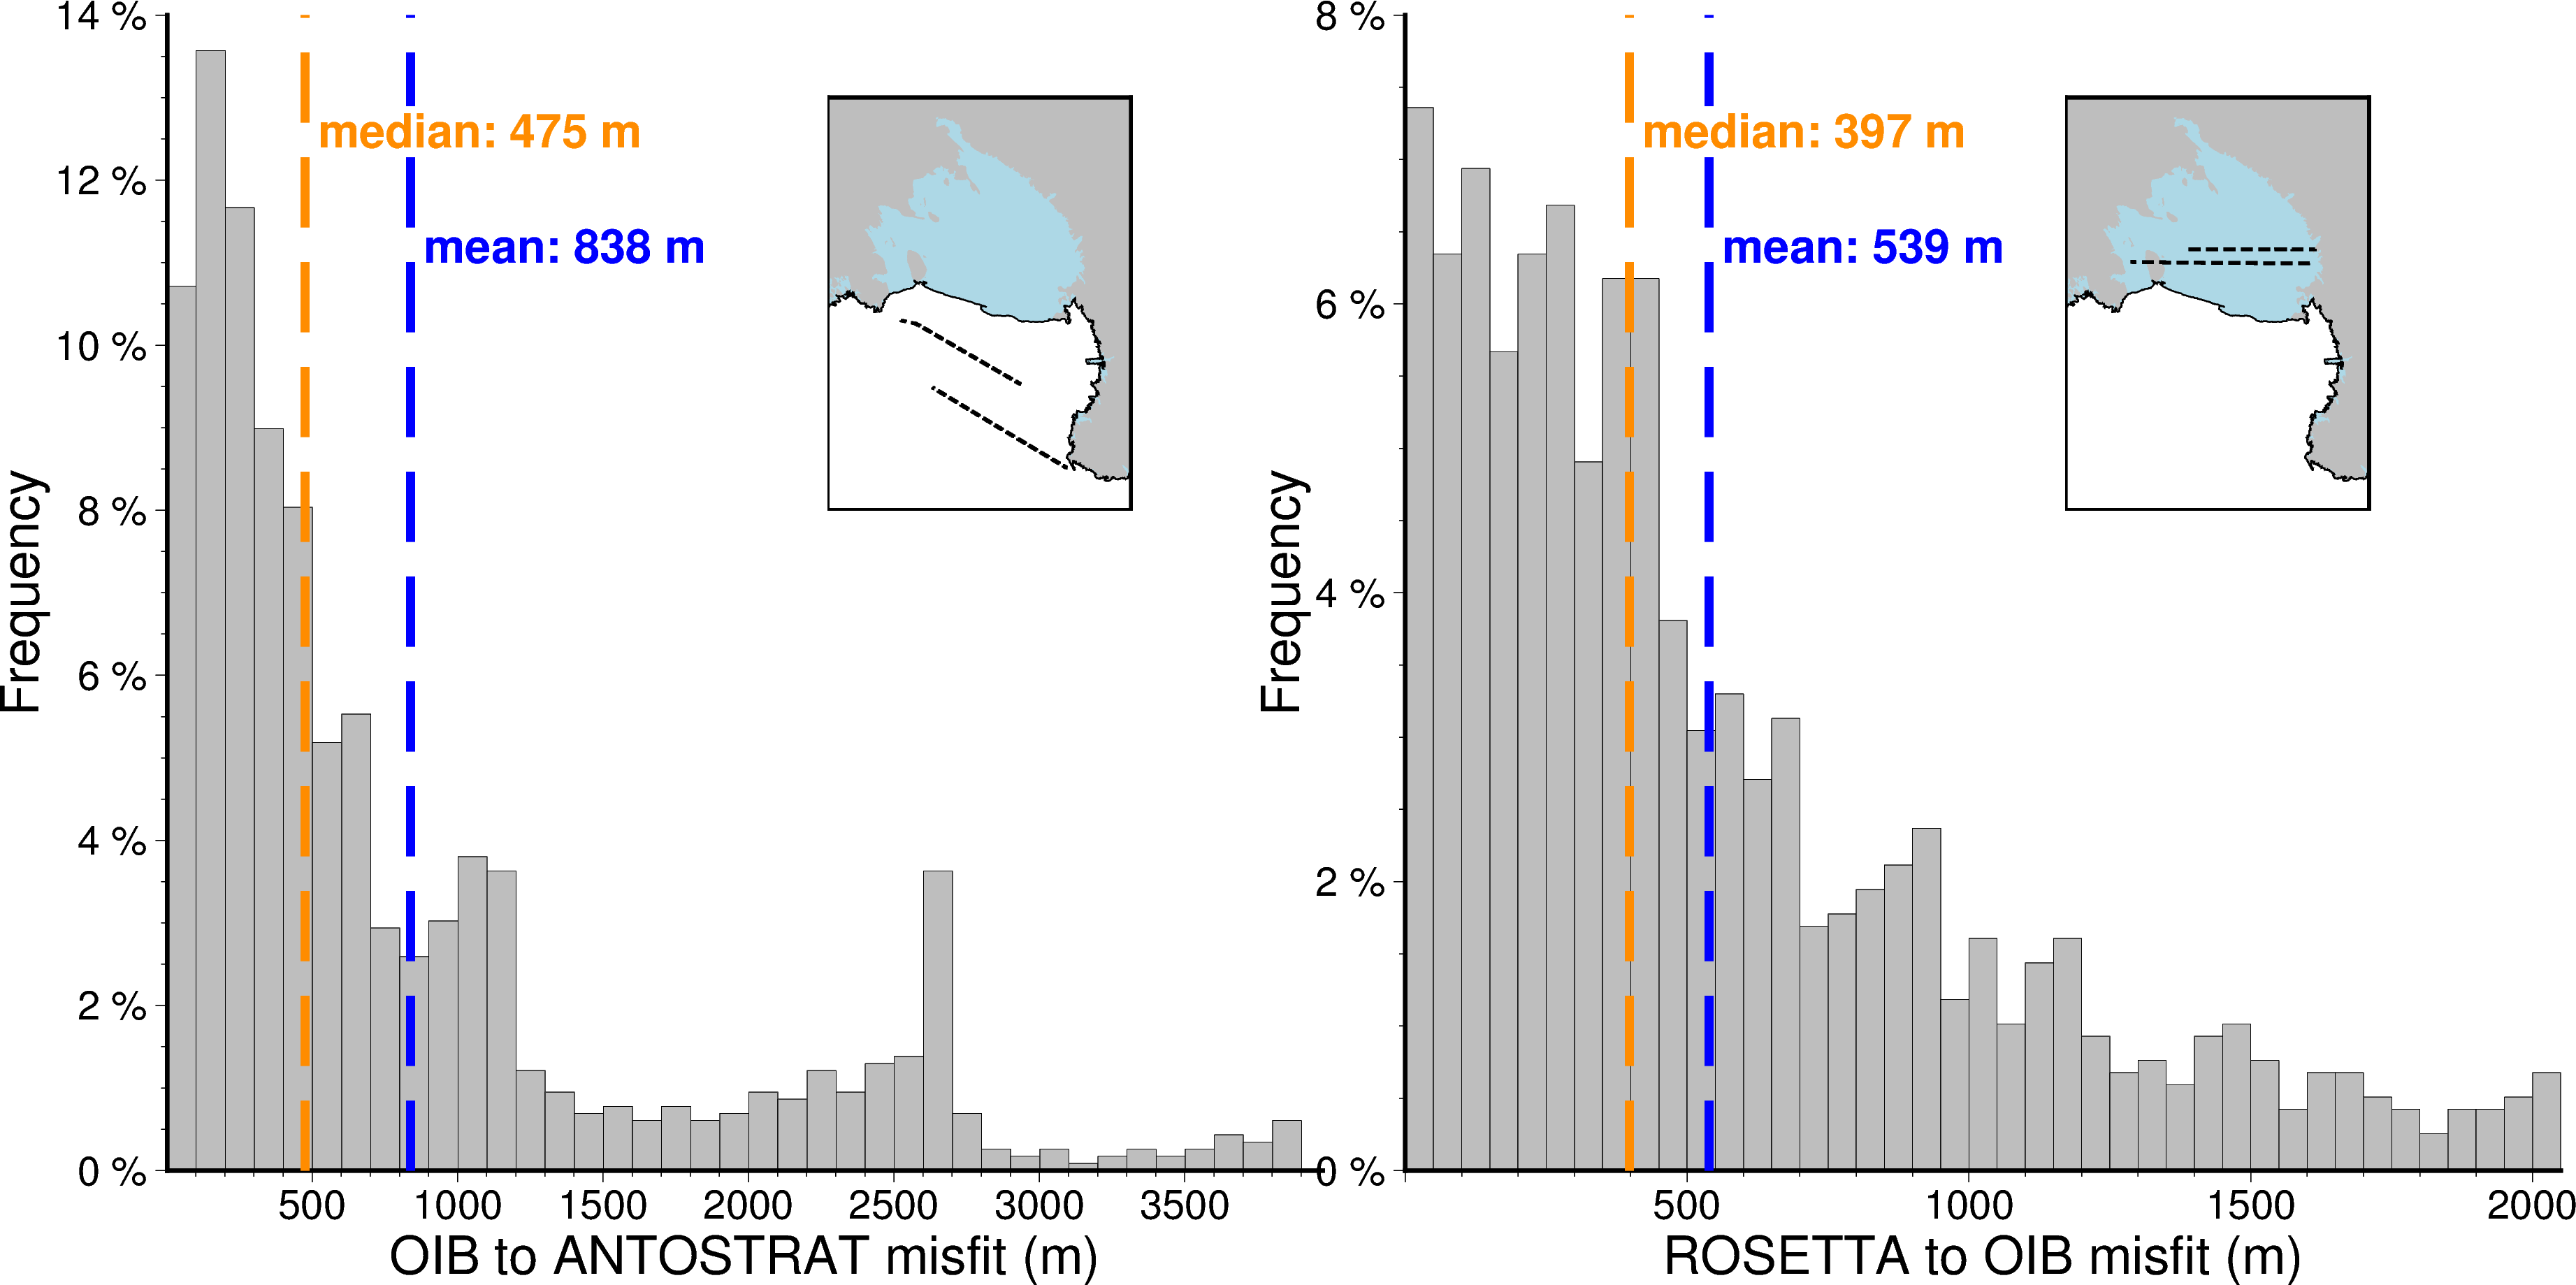

In [6]:
fig = pygmt.Figure()

data = oib_to_anto.abs_dif
upper_lim = 14

with pygmt.config(FONT_LABEL= '18p,black', FONT_ANNOT='14p,black'): 
    fig.histogram(data=data, projection='X14c',
                region=[data.min(), data.max(), 0, upper_lim],
                fill='grey',
                frame=['SW','xa500f100+l"OIB to ANTOSTRAT misfit (m)"', 'ya2f.5+l"Frequency"+u" %"'],
                series=100, # bar width in meters
                pen='.1p',
                histtype=1, # % of total data
             )
    
# add lines for mean / median valus
fig.plot(x=[data.mean(),data.mean()], y=[0,100], pen='3p,blue,-')
fig.plot(x=[data.median(),data.median()], y=[0,100], pen='3p,darkorange,-')

# add mean values as text
fig.text(x=data.mean(), y=upper_lim-upper_lim*.2, text=f' mean: {int(data.mean())} m', 
         justify='ML', font='16p,Helvetica-Bold,blue', fill='white')

# add mean values as text
fig.text(x=data.median(), y=upper_lim-upper_lim*.1, text=f' median: {int(data.median())} m', 
         justify='ML', font='16p,Helvetica-Bold,darkorange', fill='white')

# Add inset map to show location
with fig.inset(position=f'JTR+w{fig_width}c+o-6c/-6'):
    fig.plot(region=fig_reg, projection=fig_proj, 
             data = gpd.read_file('../data/shapefiles/Coastline_Antarctica_v02.shp'), color = 'lightblue')
    fig.plot(region=fig_reg, projection=fig_proj, 
             data = gpd.read_file('../data/shapefiles/GroundingLine_Antarctica_v02.shp'), color = 'grey')
    fig.plot(region=fig_reg, projection=fig_proj, 
             data = gpd.read_file('../data/shapefiles/Coastline_Antarctica_v02.shp'), frame=["nsew"], pen='0.5p,black')   
    # plot flight paths of OIB 403
    fig.plot(region=fig_reg, projection=fig_proj,
             x=df_oib_403.x[df_oib_403.Line=='L403.1'], y=df_oib_403.y[df_oib_403.Line=='L403.1'], 
             pen='1p,black,4_2:2p')                    
    fig.plot(region=fig_reg, projection=fig_proj,
             x=df_oib_403.x[df_oib_403.Line=='L403.3'], y=df_oib_403.y[df_oib_403.Line=='L403.3'], 
             pen='1p,black,4_2:2p') 


"""

Shift origin and add sublot to right

"""

fig.shift_origin(xshift='15c')

data = rosetta_to_oib.abs_dif
upper_lim = 8

with pygmt.config(FONT_LABEL= '18p,black', FONT_ANNOT='14p,black'): 
    fig.histogram(data=data, projection='X14c',
                region=[data.min(), data.max(), 0, upper_lim],
                fill='grey',
                frame=['SW','xa500f100+l"ROSETTA to OIB misfit (m)"', 'ya2f.5+l"Frequency"+u" %"'],
                series=50, # bar width in meters
                pen='.1p',
                histtype=1, # % of total data
             )
    
# add lines for mean / median valus
fig.plot(x=[data.mean(),data.mean()], y=[0,100], pen='3p,blue,-')
fig.plot(x=[data.median(),data.median()], y=[0,100], pen='3p,darkorange,-')

# add mean values as text
fig.text(x=data.mean(), y=upper_lim-upper_lim*.2, text=f' mean: {int(data.mean())} m', 
         justify='ML', font='16p,Helvetica-Bold,blue', fill='white')

# add mean values as text
fig.text(x=data.median(), y=upper_lim-upper_lim*.1, text=f' median: {int(data.median())} m', 
         justify='ML', font='16p,Helvetica-Bold,darkorange', fill='white')

# Add inset map to show location
with fig.inset(position=f'JTR+w{fig_width}c+o-6c/-6'):
    fig.plot(region=fig_reg, projection=fig_proj, 
             data = gpd.read_file('../data/shapefiles/Coastline_Antarctica_v02.shp'), color = 'lightblue')
    fig.plot(region=fig_reg, projection=fig_proj, 
             data = gpd.read_file('../data/shapefiles/GroundingLine_Antarctica_v02.shp'), color = 'grey')
    fig.plot(region=fig_reg, projection=fig_proj, 
             data = gpd.read_file('../data/shapefiles/Coastline_Antarctica_v02.shp'), frame=["nsew"], pen='0.5p,black')   
    # plot flight paths of OIB 404
    fig.plot(region=fig_reg, projection=fig_proj,
             x=df_oib_404_590.x[df_oib_404_590.Line=='L590'], y=df_oib_404_590.y[df_oib_404_590.Line=='L590'], 
             pen='1.2p,black,4_2:2p')                    
    fig.plot(region=fig_reg, projection=fig_proj,
             x=df_oib_404.x[df_oib_404.Line=='L404.650'], y=df_oib_404.y[df_oib_404.Line=='L404.650'], 
             pen='1.2p,black,4_2:2p') 

fig.show(width=400)

## Save figure

In [7]:
out='outputs/FigS6_misfits.jpg'
fig.savefig(out, dpi=400)